In [1]:
from transformers import BertTokenizer, BertModel, pipeline, AutoConfig, AutoModel, AutoModelForMaskedLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch_datasets import *

/Users/hrluo/Projects/Master/Projects_AS_24/CS4NLP/Transformers_Mechanistic_Interpretability/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# MODEL_PATH = '../logs/1l1h_top_two_max_len_3_range_64/trained'
MODEL_PATH = '../logs/3l4h_top_2_max_len_5_range_341/trained'
N_LAYERS = 3
N_HEADS = 4
USE_DATASET_GENERATION = True
# DATA_PATH = '../data/top_two_max_len_3_range_64_val.csv'

## Load Model

In [3]:
# Load pre-trained model and tokenizer
model = AutoModelForMaskedLM.from_pretrained(MODEL_PATH, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

## Get Attention Weights

In [9]:
texts = []
if USE_DATASET_GENERATION:
    # Generate dataset
    df = TopKDataset(9, 5, 2, 64, random_seed=42).data
else:
    # read in the csv file from DATA_PATH
    df = pd.read_csv(DATA_PATH)
# get the first 9 row of the dataframe
for i in range(9):
    texts.append(df.iloc[i]['text'])

# texts[0] = "29 9 62 [SEP] [MASK] [MASK]"

inputs = tokenizer(texts, return_tensors='pt')

# Get model outputs for the 9 samples
outputs = model(**inputs)
attention = outputs.attentions  # Get attention weights
# decode the output
decoded = []
for i in range(9):
    decoded.append(tokenizer.decode(outputs.logits[i].argmax(dim=-1).squeeze().tolist()[-3:-1]))
# decoded = tokenizer.decode(outputs.logits.argmax(dim=-1).squeeze().tolist())

AttributeError: 'Tensor' object has no attribute 'logits'

In [21]:
text = '4 2 5 7 6'
text += ' [SEP]'
for i in range(2):
    text += ' [MASK]'

tokenized_input = tokenizer(text, return_tensors='pt')

# Get model outputs for the 9 samples
outputs = model(**tokenized_input)
attention = outputs.attentions  # Get attention weights
# decode the output
decoded = tokenizer.decode(outputs.logits[0].argmax(dim=-1).squeeze().tolist()[-3:-1])

## Check Information

In [22]:
# print(attention)
# print shape of attention
# print([a.shape for a in attention])
print(model)

print("length of attention: ", len(attention))
print("Shape of attention[0]: ", attention[0].shape)

# for i, a in enumerate(attention):
#     print(i)
#     print(a)

DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-2): 3 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.

## Visualization
- Visualize attention for the first layer, first head (which is the only attention map for 1l1h model)
- The first dimension of an attention map (y-axis) corresponds to "query" and the second dimension (x-axis) corresponds to "key"

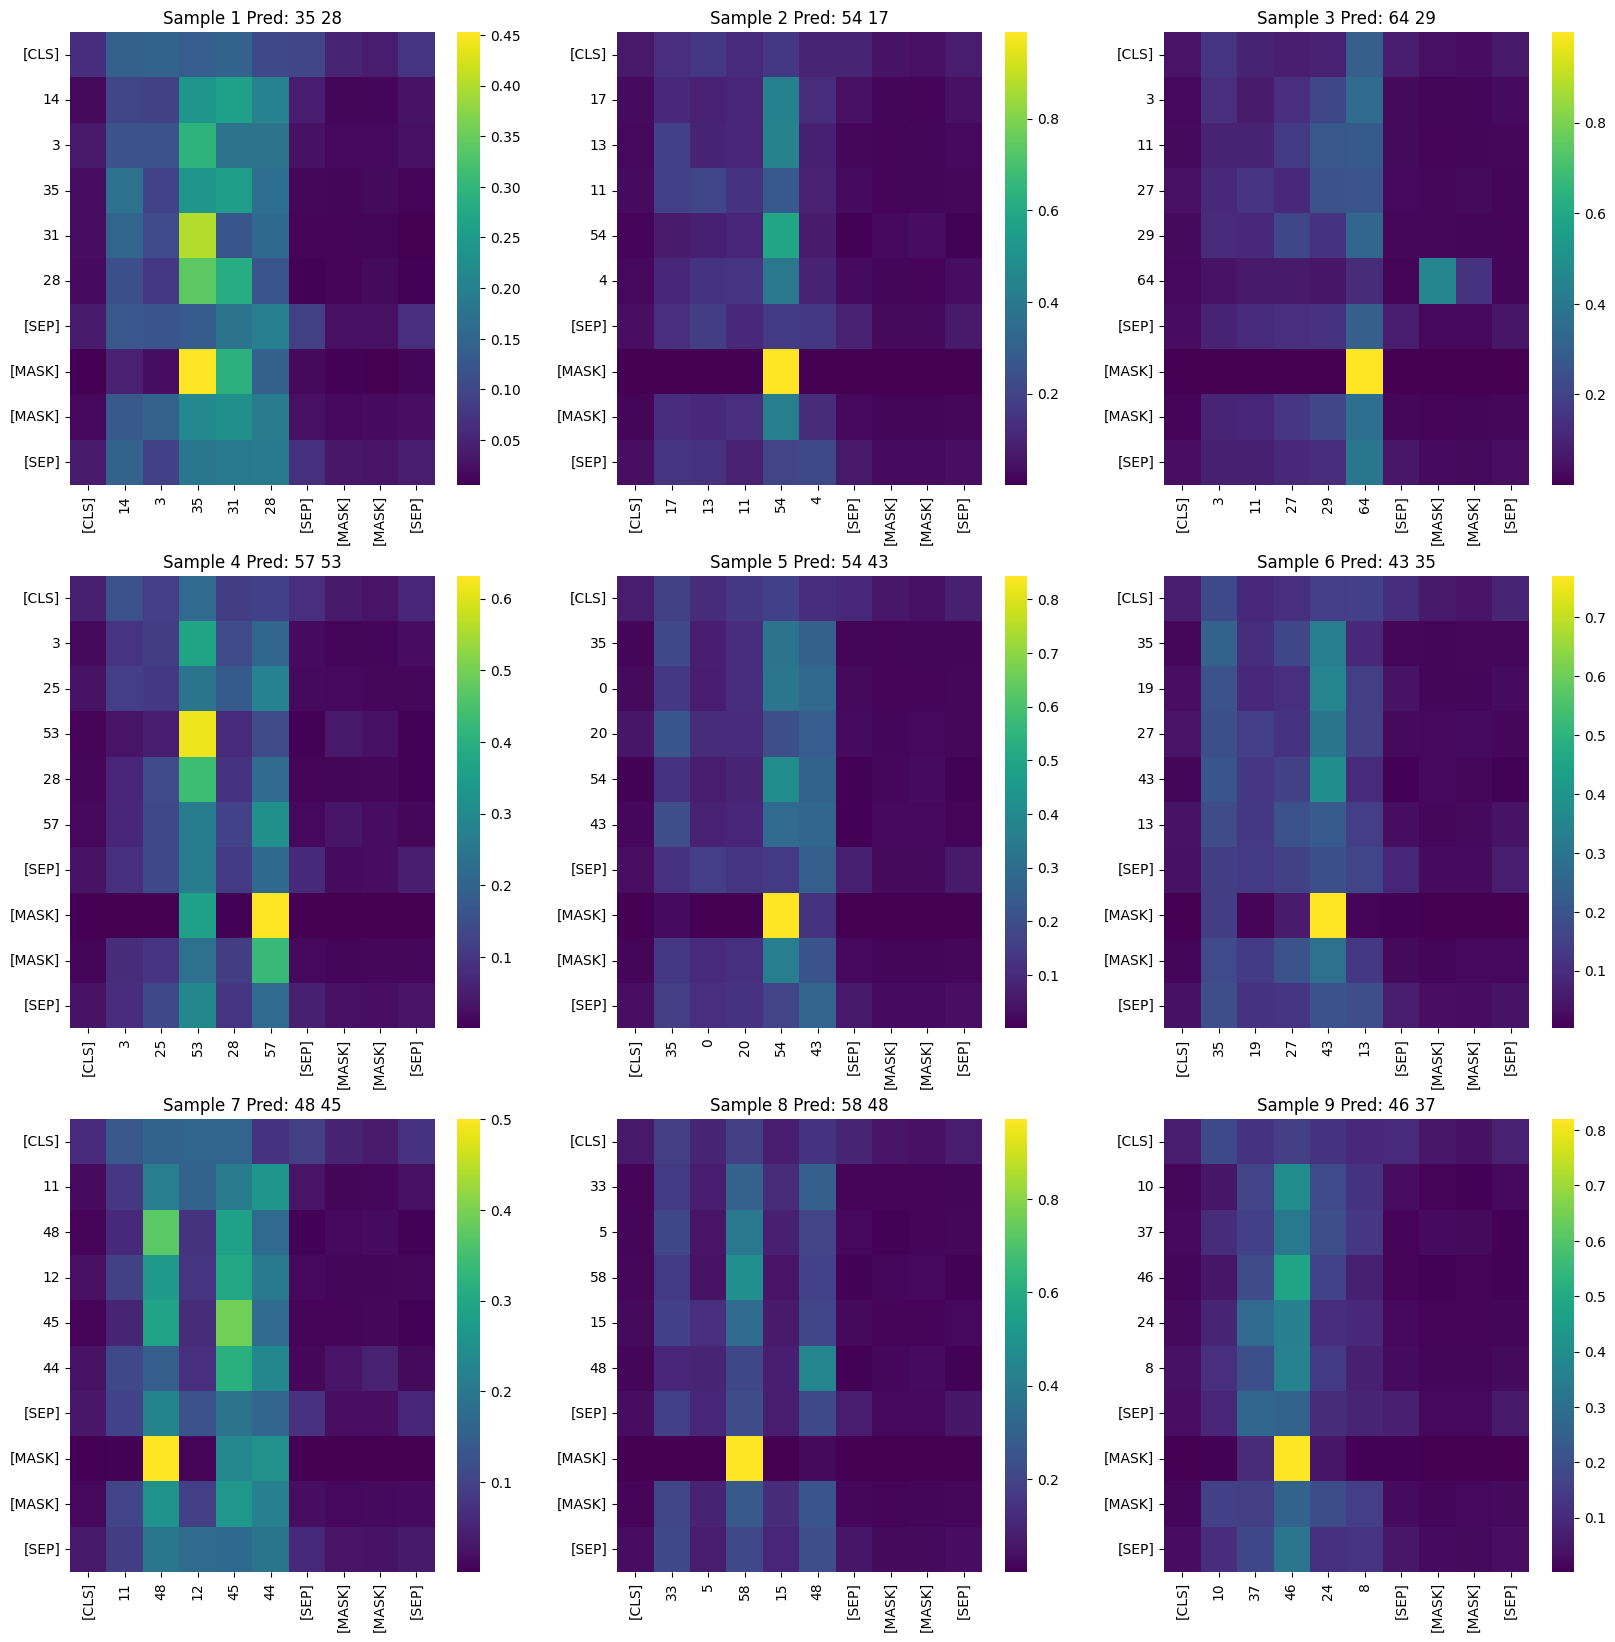

In [10]:
# Convert attention tensor to numpy
# attn = attention[0][0][0].detach().numpy()
attn = []
for i in range(9):
    attn.append(attention[0][i][0].detach().numpy())



# Plot heatmap as 9 subplots for the 9 samples
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
for i in range(9):
    sns.heatmap(attn[i], xticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][i]), yticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][i]), cmap='viridis', ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'Sample {i+1} Pred: {decoded[i]}')
plt.show()


# sns.heatmap(attn, xticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), yticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), cmap='viridis')
# plt.show()

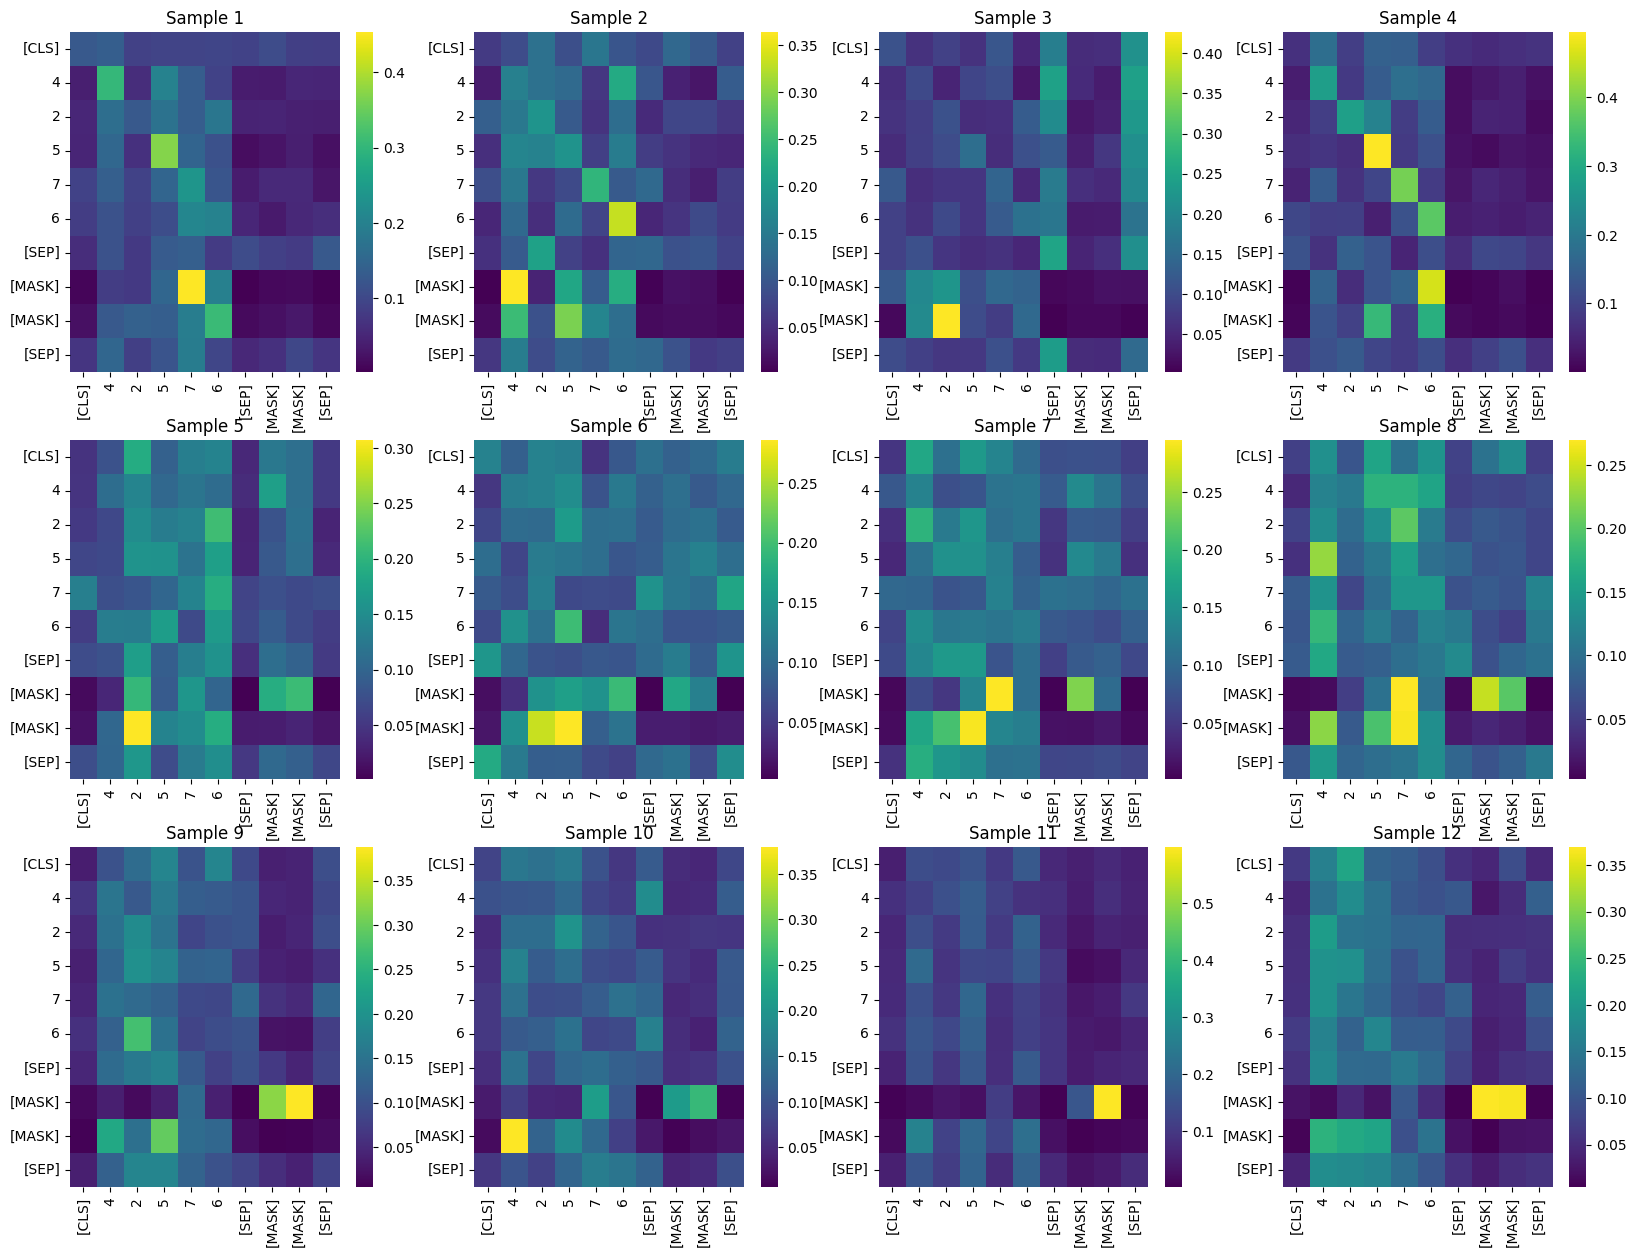

In [31]:
attn = []

for i in range(N_LAYERS):
    for j in range(N_HEADS):
        attn.append(attention[i][0][j].detach().numpy())

# Plot heatmap as 9 subplots for the 9 samples
fig, axs = plt.subplots(N_LAYERS, N_HEADS, figsize=(5*N_HEADS, 5*N_LAYERS))
for i in range(N_LAYERS * N_HEADS):
    sns.heatmap(attn[i], xticklabels=tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'][0]), yticklabels=tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'][0]), cmap='viridis', ax=axs[i//N_HEADS, i%N_HEADS])
    axs[i//N_HEADS, i%N_HEADS].set_title(f'Sample {i+1}')
plt.show()


# sns.heatmap(attn, xticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), yticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), cmap='viridis')
# plt.show()